# ФИНАЛЬНЫЙ ПРОЕКТ

In [112]:
# Импорт библиотек для проекта
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import pandahouse as ph
from scipy.stats import chi2_contingency

plt.style.use('ggplot')

In [113]:
# Выключение ворнингов
import warnings
warnings.filterwarnings('ignore')

## Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

### Подготовка данных

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [114]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';')

In [115]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [116]:
groups.shape

(74484, 2)

In [117]:
groups.dtypes

id      int64
grp    object
dtype: object

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [118]:
groups_add = pd.read_csv('Проект_2_group_add.csv')

In [119]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [120]:
groups_add.shape

(92, 2)

In [121]:
groups_add.dtypes

id      int64
grp    object
dtype: object

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [122]:
active_studs = pd.read_csv('Проект_2_active_studs.csv')

In [123]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [124]:
active_studs.shape

(8341, 1)

In [125]:
active_studs.dtypes

student_id    int64
dtype: object

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [126]:
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

In [127]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [128]:
checks.shape

(541, 2)

In [129]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

Объединим данные о принадлежности пользователя к группе в один файл

In [130]:
groups_total = groups.merge(groups_add, how='outer', on=['id', 'grp'])

In [131]:
groups_total.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [132]:
groups_total.shape

(74576, 2)

In [133]:
# Проверим все ли id после объединения уникальны
groups_total.nunique()

id     74576
grp        2
dtype: int64

Количество уникальных id соответствует количеству строк в таблице, значит в группах пользователи не повторяются

У нас есть файл active_studs.csv с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. Они и являются непосредственно участниками A/B теста. Получим информацию по ним, объединив данный файл с данными по группам пользователей и по чекам. 

In [134]:
groups_total = groups_total.rename(columns={'id': 'student_id'})

In [135]:
ab_test_students = active_studs.merge(groups_total, how='inner', on='student_id')
ab_test_students = ab_test_students.merge(checks, how='left', on='student_id').fillna(0)

In [136]:
ab_test_students.tail(10)

,student_id,grp,rev
8331,1718580,B,0.0
8332,1739983,B,0.0
8333,5008158,B,0.0
8334,4037274,A,0.0
8335,264371,B,0.0
8336,1794344,B,0.0
8337,296883,B,0.0
8338,3598448,B,0.0
8339,3610547,B,290.0
8340,205705,B,0.0


In [137]:
ab_test_students.shape

(8341, 3)

### Анализ
Поскольку цель определяется как правило до проведения А/В теста, я взяла определение цели на себя. По заданию нам не известно какие именно изменения были внесены в механику оплаты. Возможно переделали интерфейс, и тогда речь идет об удобстве оплаты. И целью проекта будет увеличение количества пользователей. Или добавили новые возможности в структуру оплаты, к примеру, кредит в корзине, отсрочка, рассрочка. Тогда основной целью проекта является увеличение среднего чека. Возможно все вместе.  


Чтобы понять, является ли новый вариант оплаты более успешным, буду использовать такие метрики как средний чек (AOV) и конверсия в покупку (CR). Средний чек поможет нам понять увеличилась ли выручка после внесенных изменений, а конверсия покажет стало ли больше пользователей покупать наш продукт.

Теперь для каждой метрики выдвинем нулевую и альтернативную гипотезы и будем их поочередно проверять.

#### AOV:
H0: После изменения механики оплаты средний чек НЕ увеличился.  
H1: После изменения механики оплаты средний чек увеличился.

Посмотрим на статистики и распределение выручки от пользователей (rev) в группах. Нас интересуют пользователи, которые совершили оплату, поэтому исключим из выборок пользователей с нулевой оплатой.

In [138]:
ab_test_aov = ab_test_students.query('rev != 0')

In [139]:
ab_test_aov.groupby('grp', as_index=False).agg({'student_id': 'count'})

,grp,student_id
0,A,78
1,B,314


In [140]:
ab_test_aov.groupby('grp', as_index=False).agg({'rev': 'mean'})

,grp,rev
0,A,933.589744
1,B,1257.878992


In [141]:
ab_test_aov.groupby('grp', as_index=False).agg({'rev': 'median'})

,grp,rev
0,A,585.0
1,B,1140.0


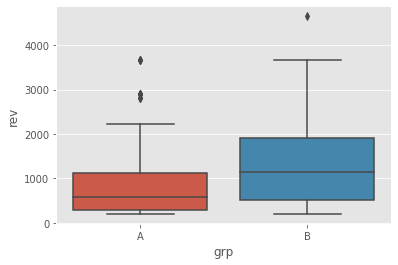

In [142]:
sns.boxplot(x=ab_test_aov.grp, y=ab_test_aov.rev)

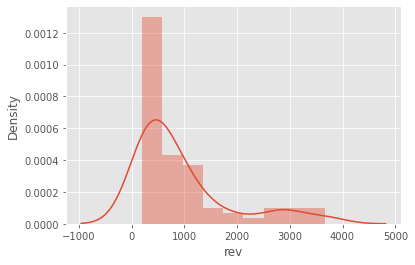

In [143]:
# Группа А
sns.distplot(ab_test_aov.query('grp == "A"').rev)

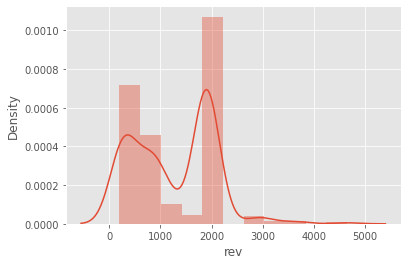

In [144]:
# Группа В
sns.distplot(ab_test_aov.query('grp == "B"').rev)

На первый взгляд в группе В результат лучше - средний чек больше (в нашем случае среднее эквивалентно среднему чеку). 
Теперь проверим насколько статистически значимыми являются различия. Является ли увеличение среднего чека результатом изменений или это результат случайности.

В обеих группах количество участников теста различно и оба распределения отличаются от нормального. Поэтому для проверки статистических гипотез буду использовать метод Bootstrap. 

In [145]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

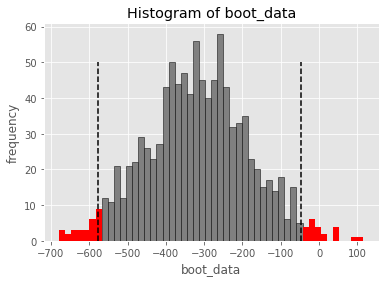

In [146]:
# Передадим данные по нашим двум группам
# В результате хранится разница двух распределений, доверительный интервал и pvalue
booted_data = get_bootstrap(ab_test_aov.query('grp == "A"').rev, 
                            ab_test_aov.query('grp == "B"').rev)

In [147]:
booted_data["p_value"]  # альфа

0.01788390417955473

In [148]:
booted_data["quants"]  # ДИ

,0
0.025,-576.870206
0.975,-47.573410


В результате проведенного теста мы получили доверительный интервал для бутсрапированных разниц средних (где 0 не входит в доверительный интервал) и p_value < 0,05. Это позволяет нам отклонить нулевую гипотезу, и принять альтернативную.  
#### Мы можем сделать вывод, что после изменения механики оплаты средний чек увеличился.

#### Но с оговорками:

- Выборка является действительно репрезентативной, и мы доверяем нашим данным, полученным в результате А/В теста.

Теперь перейдем к проверке следующей метрики.

CR:  
H0: После изменения механики оплаты конверсия в покупку НЕ увеличилась.  
H1: После изменения механики оплаты конверсия в покупку увеличилась.

In [149]:
ab_test_cr = ab_test_students.copy()

In [150]:
# Переведем факт оплаты в 1, и оставим 0, если оплаты не было
ab_test_cr['rev'] = ab_test_cr.rev.apply(lambda x: 1 if x != 0 else x)

In [151]:
groups = ab_test_cr.groupby(['grp', 'rev'], as_index=False).size()
groups

,grp,rev,size
0,A,0.0,1460
1,A,1.0,78
2,B,0.0,6489
3,B,1.0,314


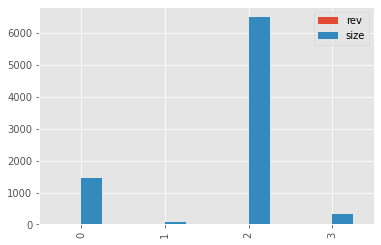

In [152]:
groups.plot.bar()

In [153]:
# CR группы А
ab_test_cr.query('grp == "A"').rev.sum() / ab_test_cr.query('grp == "A"').rev.count()

0.05071521456436931

In [154]:
# CR группы В
ab_test_cr.query('grp == "B"').rev.sum() / ab_test_cr.query('grp == "B"').rev.count()

0.046156107599588415

Видно, что разница CR в группах совсем маленькая.  

После преобразований факта оплаты в 0 и 1 на выходе получились категориальные данные, поэтому для проверки статзначимости буду использовать метод Хи-квадрат.

In [155]:
# Перераспределим данные в 2x2 для Хи-квадрат
# Для этого разделим данные на группы и сформируем массив

A_1 = ab_test_cr.query('grp == "A"').rev.sum()
A_0 = ab_test_cr.query('grp == "A"').rev.count() - A_1
B_1 = ab_test_cr.query('grp == "B"').rev.sum()
B_0 = ab_test_cr.query('grp == "B"').rev.count() - B_1

obs = np.array([[A_1, A_0], [B_1, B_0]])

In [156]:
obs

array([[  78., 1460.],
       [ 314., 6489.]])

In [157]:
chi2_contingency(obs)[1]

0.48625240457231045

В результате проведенного теста мы получили p_value = 0.49, что значительно превышает уровень значимости 0,05. Полученные статистические данные не позволяют нам отклонить нулевую гипотезу.  
#### Мы можем сделать вывод, что после изменения механики оплаты конверсия не увеличилась.

### Подведем итоги. 

Анализируя результаты проведенного А/В-теста, мы получили статзначимые различия по метрике AOV(средний чек), которые позволяют нам отклонить нулевую гипотезу. И сказать, что вероятность того, что выборочный средний чек в результате изменения механики оплаты вырос и не является результатом случайной флуктуации, очень велика.
И статистически мы не смогли подтвердить гипотезу о том, что CR (конверсия) у нас увеличилась.

#### И основной вопрос. Стоит ли запускать новую механику на всех пользователей?  
Если у нас есть еще возможности и ресурсы на проведение А/В теста, то я бы рекомендовала его продлить, чтобы накопить больше данных для исследования.
Но если мы ограничены только текущими данными, я бы ответила, что стоит. Поскольку основная цель бизнеса - увеличение прибыли. И если один из показателей говорит о том, что прибыль увеличилась, то новые изменения стоит запускать.

## Задание 2. SQL

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица default.peas:

Название атрибута|Тип атрибута|Смысловое значение
:----------------|:-----------|:----------------
st_id|int|ID ученика  
timest|timestamp|Время решения карточки
correct|bool|Правильно ли решена горошина?
subject|text|Дисциплина, в которой находится горошина

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.  

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.  

In [2]:
user = '****'
password = '****'

In [159]:
connection_default = {
    'host': '****',
    'database': '****',
    'user': user, 
    'password': password
}

Поскольку данных может быть много за несколько лет, я группирую горошины по месяцам и годам, чтобы в один месяц не попали горошины за несколько лет. И группирую по предметам, потому что один студент условно может решить 20 горошин по 20 предметам. На мой взгляд это не говорит о том, что он является усердным учеником. Возможно он тестировал, какой предмет ему больше интересен. Поэтому я решила, что группировка по предметам лучше отражает усердных учеников.

In [160]:
query_sql = '''
SELECT
    COUNT(st_id) AS quantity_of_best_students
FROM (
    SELECT
        st_id,
        toMonth(timest) AS month,
        toYear(timest) AS year,
        COUNT (st_id) AS peas
    FROM
        default.peas
    WHERE
        correct = 1
    GROUP BY
        st_id,
        month,
        year,
        subject

    ORDER BY
        st_id) AS peas

WHERE
    peas >= 20
'''

In [161]:
q_result = ph.read_clickhouse(query=query_sql, connection=connection_default)
q_result

,quantity_of_best_students
0,93



2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

Название атрибута|Тип атрибута|Смысловое значение
:----------------|:-----------|:-----------------
st_id|int|ID ученика
test_grp|text|Метка ученика в данном эксперименте

и default.final_project_check:

Название атрибута|Тип атрибута|Смысловое значение
:----------------|:-----------|:-----------------
st_id|int|ID ученика
sale_time|timestamp|Время покупки
money|int|Цена, по которой приобрели данный курс
subject|text|Дисциплина, на которую приобрели полный доступ

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU   
- ARPAU   
- CR в покупку   
- СR активного пользователя в покупку   
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике  

ARPU считается относительно всех пользователей, попавших в группы.  

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

Все данные находятся в табличном виде в Clickhouse

In [162]:
query_sql = '''
SELECT
   total.test_grp,
   ROUND(total.sum_money/total.total_st,2) AS ARPU,
   ROUND(active.sum_money_active_st/active.active_st,2) AS ARPAU, 
   ROUND(total.paying_st/total.total_st * 100, 2) AS CR,
   ROUND(active.paying_active_st/active.active_st * 100, 2) AS CR_active_st,
   ROUND(math.math_paying_st/math.math_active_st * 100, 2) AS CR_math_active_st
FROM
    (
    SELECT
        test_grp AS test_grp,
        SUM(money) AS sum_money,
        COUNT(DISTINCT st_id) AS total_st,
        COUNT(DISTINCT (IF (money>0, st_id, NULL))) AS paying_st
    FROM
        default.studs AS studs
    LEFT JOIN
        default.final_project_check AS check
    ON studs.st_id = check.st_id
    GROUP BY
        test_grp
    )AS total
JOIN
    (
    SELECT
        test_grp,
        COUNT(st_id) AS active_st,
        SUM(sum_money) AS sum_money_active_st,
        COUNT(DISTINCT (IF (sum_money>0, st_id, NULL))) AS paying_active_st
    FROM
        (
        SELECT
            test_grp,
            st_id,
            SUM(money) AS sum_money
        FROM
            (
            SELECT
                test_grp,
                st_id,
                SUM(correct) AS correct_peas
            FROM
                default.studs AS studs
            LEFT JOIN
                default.peas AS peas
            ON studs.st_id = peas.st_id
            WHERE correct = 1
            GROUP BY
                test_grp,
                st_id
            HAVING
                correct_peas > 10
            ) AS active_st
        LEFT JOIN
            default.final_project_check AS check
        ON active_st.st_id = check.st_id
        GROUP BY
            test_grp,
            st_id
            )
    GROUP BY
        test_grp
    ) AS active
ON total.test_grp = active.test_grp
JOIN
    (
    SELECT
        test_grp,
        COUNT(DISTINCT st_id) AS math_active_st,
        SUM(sum_money) AS math_sum_money,
        COUNT(DISTINCT (IF (sum_money>0, st_id, NULL))) AS math_paying_st
    FROM
        (
        SELECT
            test_grp,
            st_id,
            SUM(money) AS sum_money
        FROM
            (
            SELECT
                test_grp,
                st_id,
                SUM(correct) AS correct_peas
            FROM
                default.studs AS studs
            LEFT JOIN
                default.peas AS peas
            ON studs.st_id = peas.st_id
            WHERE correct = 1 AND subject = 'Math'
            GROUP BY
                test_grp,
                st_id
            HAVING
                correct_peas >= 2
            ) AS active_st
        LEFT JOIN
            default.final_project_check AS check
        ON active_st.st_id = check.st_id
        GROUP BY
            test_grp,
            st_id
            )
    GROUP BY
        test_grp
    ) AS math
ON total.test_grp = math.test_grp
'''

In [163]:
q_result = ph.read_clickhouse(query=query_sql, connection=connection_default)
q_result

,total.test_grp,ARPU,ARPAU,CR,CR_active_st,CR_math_active_st
0,control,4540.98,10393.70,4.92,11.02,10.20
1,pilot,11508.47,29739.58,10.85,26.04,14.29


## Задание 3. Python

3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Предположим по результатам проведенного А/В теста из Задания 1 было принято решение продлить тестирование. 

Прочитаем заново файлы из Задания 1, и сформируем результирующую таблицу ab_test_students, которая будет регулярно пополняться новыми данными из файла groups_add.csv.

In [164]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
active_studs = pd.read_csv('Проект_2_active_studs.csv')
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

In [165]:
# Получим результирующую таблицу ab_test_students 
groups = groups.rename(columns={'id': 'student_id'})
ab_test_students = active_studs.merge(groups, how='inner', on='student_id')
ab_test_students = ab_test_students.merge(checks, how='left', on='student_id').fillna(0)

In [166]:
# Функция реализует пересчет метрик 

# Для расчета доступны следующие метрики: 'AOV', 'CR'
# Название метрики должно строго соответствовать указанным названиям, 
# в противном случае расчет не произведется

def get_metric(
    path_to_file,  # путь к файлу
    metric  # метрика 
):
    
    groups_add = pd.read_csv(path_to_file, sep=',')
    groups_add = groups_add.rename(columns={groups_add.columns[0]: 'student_id', 
                                            groups_add.columns[1]: 'grp'})
    
    groups_add = active_studs.merge(groups_add, how='inner', on='student_id')
    groups_add = groups_add.merge(checks, how='left', on='student_id').fillna(0) 
    
    # Соединим с таблицей ab_test_students 
    ab_test_total = ab_test_students.merge(groups_add, how='outer')
    
    if metric == 'AOV':      
        metric_result = ab_test_total.query('rev != 0')\
            .groupby('grp', as_index=False)\
            .agg({'rev': 'mean'})\
            .rename(columns={'rev': 'AOV'})\
            .round(2)
        
    elif metric == 'CR':
        # Переведем факт оплаты в 1, и оставим 0, если оплаты не было
        ab_test_total['rev'] = ab_test_total.rev.apply(lambda x: 1 if x != 0 else x)
        metric_result = pd.DataFrame(
            [
                ['A', 
                 round(
                     ab_test_total.query('grp == "A"').rev.sum() / ab_test_total.query('grp == "A"').rev.count(), 3)],
                ['B', 
                 round(
                     ab_test_total.query('grp == "B"').rev.sum() / ab_test_total.query('grp == "B"').rev.count(), 3)]
            ],
            columns=['grp', 'CR']
        )
    else:
        metric_result = print('Данная функция не производит расчет метрики ', metric) 
  
    return metric_result

In [167]:
# Путь к файлу
path_to_file = 'Проект_2_group_add.csv'
# Название метрики
metric = 'AOV'

In [168]:
# Передадим параметры и вызовем функцию 
metric_result = get_metric(path_to_file, metric)
metric_result

,grp,AOV
0,A,933.59
1,B,1257.88


Поскольку используемые метрики (AOV, CR) содержат всего одно значение, реализована функция, которая строит барплот для наглядности разницы между группами А и В.

In [169]:
# Функция строит барплот по получаемым метрикам
# Где x - колонка [0] в таблице,
#     y - колонка [1] в таблице.

def get_chart(
    metric  # метрика 
):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metric_result[metric_result.columns[0]], y=metric_result[metric_result.columns[1]]) 

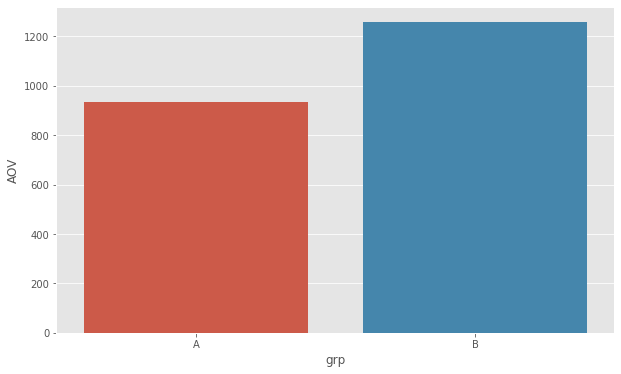

In [170]:
# Построим график для метрики
# В переменной metric_result хранится значение полученной ранее метрики 
get_chart(metric_result)